In [1]:
# 1. Module Import 
import numpy as np                              # 선형대수를 위한 NumPy 라이브러리 불러오기
import matplotlib.pyplot as plt                 # 데이터 시각화를 위한 Matplotlib 라이브러리 불러오기

import torch                                    # PyTorch 라이브러리 불러오기 (딥러닝 프레임워크)
import torch.nn as nn                           # 신경망 모델 생성을 위한 모듈 불러오기
import torch.nn.functional as F                 # 활성화 함수 등 신경망 관련 주요 함수들 불러오기
from torchvision import transforms, datasets    # 이미지 데이터 전처리 및 데이터셋 다운로드를 위한 torchvision 모듈 불러오기

In [2]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 

if torch.cuda.is_available():                  # 만약 CUDA(GPU)가 사용 가능하면
    DEVICE = torch.device('cuda')              # 장치를 GPU로 설정
else: 
    DEVICE = torch.device('cpu')              # 그렇지 않으면 장치를 CPU로 설정

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)  # 사용 중인 PyTorch 버전과 선택된 장치 출력



Using PyTorch version: 2.8.0+cu126 Device: cuda


In [3]:
# 3.하이퍼 파라미터 정의 
BATCH_SIZE = 32
EPOCHS = 10


In [4]:
# 4. Data Augmentation이 적용된 CIFAR-10 데이터 다운로드(Train set, Test set 분리하기)

train_dataset = datasets.CIFAR10(
    root      = "../data/CIFAR_10",          # 데이터 저장 경로
    train     = True,                        # 학습용 데이터 여부
    download  = True,                        # 데이터 없으면 다운로드
    transform = transforms.Compose([         # 이미지 데이터에 다양한 Augmentation을 적용 
        transforms.RandomHorizontalFlip(),   # 50% 확률로 랜덤 좌우반전
        transforms.ToTensor(),               # 딥러닝 모델에 Input으로 이용될 수 있도록 0에서 1사이의 값으로 정규화하며 ToTensor 형태로 변환
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #ToTensor 형태로 변환된 이미지에 추가 정규화 진행 (red,green,blue)순으로 평균&표준편차를 0.5씩 적용 
        ])       
)

test_dataset = datasets.CIFAR10(
    root      = "../data/CIFAR_10",          # 데이터 저장 경로
    train     = False,                       # 테스트용 데이터 여부
    transform = transforms.Compose([         # 이미지 데이터에 다양한 Augmentation을 적용 
        transforms.RandomHorizontalFlip(),   # 50% 확률로 랜덤 좌우반전
        transforms.ToTensor(),               # 딥러닝 모델에 Input으로 이용될 수 있도록 0에서 1사이의 값으로 정규화하며 ToTensor 형태로 변환
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #ToTensor 형태로 변환된 이미지에 추가 정규화 진행 (red,green,blue)순으로 평균&표준편차를 0.5씩 적용 
        ])
)

train_loader = torch.utils.data.DataLoader(
    dataset    = train_dataset,              # 학습용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = True                        # 데이터 섞기
)

test_loader = torch.utils.data.DataLoader(
    dataset    = test_dataset,               # 테스트용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = False                       # 순서 유지
)


In [7]:
# 5. 데이터 확인하기 (1)
for (x_train, y_train) in train_loader:                         # 학습용 데이터 로더에서 배치 단위로 데이터를 가져옴
    print('x_train:', x_train.size(), 'type:', x_train.type())  # 입력 이미지 텐서의 크기와 자료형 출력
    print('y_train:', y_train.size(), 'type:', y_train.type())  # 정답 라벨 텐서의 크기와 자료형 출력
    break                                                       # 첫 번째 배치만 확인하고 반복 종료


x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5529412..0.79607844].
Cli

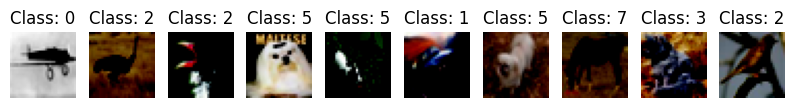

In [8]:
# 6. 데이터 확인하기 (2)
pltsize = 1                                             # 출력 이미지 크기 설정
plt.figure(figsize=(10 * pltsize, pltsize))             # 전체 그림 크기 설정 (가로로 10개 이미지)

for i in range(10):                                     # 처음 10개 이미지에 대해 반복
    plt.subplot(1, 10, i + 1)                           # 1행 10열의 서브플롯 중 i번째 위치
    plt.axis('off')                                     # 축(좌표) 숨기기
    plt.imshow(np.transpose(x_train[i],(1,2,0)))        # (C,H,W) → (H,W,C)로 변환 후 이미지 출력
    plt.title('Class: ' + str(y_train[i].item()))       # 해당 이미지의 클래스(숫자 라벨) 표시

In [ ]:
# 7. ResNet 모델 설계

# ----------------------------
# BasicBlock 정의
# ----------------------------
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        
        # 1. 첫 번째 3x3 convolution
        # in_planes: 입력 채널 수, planes: 출력 채널 수
        # stride: 다운샘플링 여부
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # 배치정규화
        
        # 2. 두 번째 3x3 convolution
        # 항상 stride=1
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # 3. Shortcut 정의
        # 입력과 출력의 채널 수나 공간 크기가 다르면 변환 필요
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            # 1x1 conv로 채널 수 맞추고 stride로 다운샘플링
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        # 메인 브랜치
        out = F.relu(self.bn1(self.conv1(x)))  # conv1 → BN → ReLU
        out = self.bn2(self.conv2(out))        # conv2 → BN
        
        # Shortcut 더하기
        out += self.shortcut(x)
        out = F.relu(out)                       # 최종 ReLU
        return out

# ----------------------------
# ResNet 정의
# ----------------------------
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 16  # 현재 블록으로 들어오는 채널 수 초기화

        # 1. 입력 이미지(3채널) → 16채널 feature map
        self.conv1 = nn.Conv2d(3, 16,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # 2. Residual Layer들 생성
        self.layer1 = self._make_layer(16, 2, stride=1)  # 채널 16, 블록 2개
        self.layer2 = self._make_layer(32, 2, stride=2)  # 채널 32, stride=2 → 다운샘플링
        self.layer3 = self._make_layer(64, 2, stride=2)  # 채널 64, stride=2 → 다운샘플링

        # 3. 마지막 출력 레이어
        self.linear = nn.Linear(64, num_classes)

    # ----------------------------
    # Residual Layer를 만드는 헬퍼 함수
    # ----------------------------
    def _make_layer(self, planes, num_blocks, stride):
        # 첫 블록만 stride 적용, 나머지는 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes  # 다음 블록 입력 채널 수 갱신
        return nn.Sequential(*layers)

    # ----------------------------
    # Forward 정의
    # ----------------------------
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # conv1 → BN → ReLU
        out = self.layer1(out)                 # Layer1 통과
        out = self.layer2(out)                 # Layer2 통과
        out = self.layer3(out)                 # Layer3 통과
        out = F.avg_pool2d(out, 8)             # Global Average Pooling (8x8 → 1x1)
        out = out.view(out.size(0), -1)        # Flatten
        out = self.linear(out)                 # Linear layer → 클래스 출력
        return out

In [19]:
# 8. Optimizer(최적화 알고리즘), Objective Function(손실 함수)설정 


model = ResNet().to(DEVICE)                                    # NET 클래스의 인스턴스를 생성하고, 지정된 DEVICE(GPU 또는 CPU)로 모델을 이동시킴
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 모델의 파라미터를 Adam 최적화 알고리즘으로 업데이트하도록 설정 (학습률 0.001)

criterion = nn.CrossEntropyLoss()                           # ***중요 주의점***
                                                            # 분류 문제(CIFAR-10)에서는 반드시 CrossEntropyLoss를 사용해야 함
                                                            # 이전에 오토인코더 코드에서 MSELoss를 그대로 가져오면
                                                            #   - 모델 출력 크기(배치×10)와 라벨 크기(배치)가 맞지 않아
                                                            #   - RuntimeError: tensor size mismatch 오류가 발생함
                                                            # CrossEntropyLoss는 정수 라벨을 자동으로 처리하며
                                                            # 내부적으로 softmax + NLLLoss가 결합된 형태로 동작함
                                                            
print(model)                                                # 모델 구조를 출력 — 각 층의 구성과 파라미터 정보를 확인할 수 있음

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [15]:
# 9. NET 모델 학습을 진행하며 학습 데이터 대한 모델 성능을 확인하는 함수 정의 

def train(Epoch,model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item():.6f}")
        

In [16]:
# 10. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy =100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy  


In [20]:
# 11. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기 
for Epoch in range(1,EPOCHS+1):
    train(Epoch,model,train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n")


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.304388
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.593328
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.320684
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.283368
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.279073
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.311055
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 0.990604
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.216499

[EPOCH]: 1, 	Test Loss: 0.0326, 	Test Accuracy: 62.55 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.843532
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 0.805284
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 0.782226
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.175035
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.001049
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.174950
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 0.983814
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.146520

[EPOCH]: 2, 	Test Loss: 0.0276, 	Test Accuracy: 69.80 %

Train Epoch: 3 [